<a href="https://colab.research.google.com/github/SDS-AAU/dsba-cbs/blob/master/M3/workshop/Multivariate_time_series_LSTM_easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pandas_datareader import data as pdr

In [2]:
ibm = pdr.DataReader('IBM','stooq', start="2017-12-01", end="2020-12-01")
aapl = pdr.DataReader('AAPL','stooq', start="2017-12-01", end="2020-12-01")
tesla = pdr.DataReader('TSLA','stooq', start="2017-12-01", end="2020-12-01")
gm =  pdr.DataReader('GM','stooq', start="2017-12-01", end="2020-12-01")

In [3]:
data = pd.DataFrame({'IBM':ibm['Close'], 'AAPL':aapl['Close'], 'TSLA':tesla['Close'], 'GM': gm['Close']})

In [4]:
data = data.sort_index(ascending=True)

In [5]:
data

,IBM,AAPL,TSLA,GM
Date,,,,
2017-12-01,134.24,41.154,61.306,38.623
2017-12-04,135.71,40.852,61.040,38.857
2017-12-05,134.76,40.815,60.740,38.632
2017-12-06,133.67,40.668,62.654,38.045
2017-12-07,133.21,40.735,62.252,38.272
...,...,...,...,...
2020-11-24,124.42,115.170,555.380,46.460
2020-11-25,124.20,116.030,574.000,45.460
2020-11-27,124.35,116.590,585.760,45.060


In [6]:
data['TSLA_y'] = data['TSLA'].shift(-1, fill_value=data['TSLA'].iloc[-1])

In [8]:
test_size = int(len(data) * 0.2) # the test data will be 10% (0.1) of the entire data
train = data.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = data.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(604, 5) (151, 5)


In [9]:
train

,IBM,AAPL,TSLA,GM,TSLA_y
Date,,,,,
2017-12-01,134.24,41.154,61.306,38.623,61.040
2017-12-04,135.71,40.852,61.040,38.857,60.740
2017-12-05,134.76,40.815,60.740,38.632,62.654
2017-12-06,133.67,40.668,62.654,38.045,62.252
2017-12-07,133.21,40.735,62.252,38.272,63.026
...,...,...,...,...,...
2020-04-22,114.55,68.594,146.420,21.300,141.130
2020-04-23,116.50,68.332,141.130,21.520,145.030
2020-04-24,119.74,70.304,145.030,21.950,159.750


In [10]:
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values

X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values

In [11]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [12]:
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1,1))

In [13]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)


In [14]:
print(generator[0][0].shape)

(32, 25, 4)


In [15]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               93000     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 93,151
Trainable params: 93,151
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(generator,epochs=5)

Epoch 1/5
19/19 [==============================] - 1s 31ms/step - loss: 0.1357
Epoch 2/5
19/19 [==============================] - 1s 31ms/step - loss: 0.0358
Epoch 3/5
19/19 [==============================] - 1s 31ms/step - loss: 0.0189
Epoch 4/5
19/19 [==============================] - 1s 32ms/step - loss: 0.0155
Epoch 5/5
19/19 [==============================] - 1s 31ms/step - loss: 0.0147


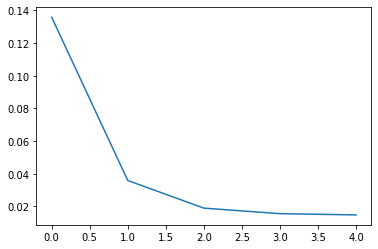

In [17]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [18]:
test_generator = TimeseriesGenerator(X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 25, 4)


In [19]:
y_pred_scaled = model.predict(test_generator)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({'y_true':y_test.flatten()[n_input:],'y_pred':y_pred.flatten()})
print(results)

     y_true      y_pred
0    177.13  161.790558
1    189.98  161.727219
2    188.13  162.270233
3    205.01  164.049713
4    194.57  165.484329
..      ...         ...
121  574.00  374.011597
122  585.76  391.209839
123  567.60  410.407776
124  584.76  429.880157
125  584.76  444.418243

[126 rows x 2 columns]


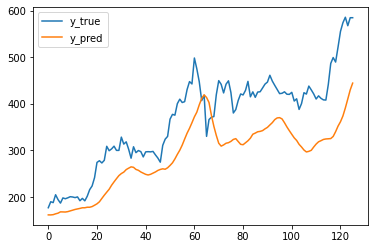

In [20]:
results.plot()